In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from quantities import ns, s
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
import matplotlib.pyplot as plt
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  'you are using the python implementation of fast fca')


In [3]:
def load_data(recording, data_dir, verbose):
    if verbose:
        print('Loading data:\t{}'.format(recording))
    path = ''.join([os.path.join(data_dir, recording, recording), '.csv'])
    return pd.read_csv(path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_time_series(df):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    return df


def get_condition_times(df, experiment):
    if experiment == 'DREADD':
        max_time = df[df['condition'] == 'CNO']['time'].iloc[-1].total_seconds()
        max_time = list(zip(['CNO'], [max_time]))
        n_conditions = 1
    elif experiment == 'CIT':
        max_time_cit = df[df['condition'] == 'CIT']['time'].iloc[-1].total_seconds()
        if 'WAY' in df['condition'].values:
            max_time_way = df[df['condition'] == 'WAY']['time'].iloc[-1].total_seconds()
            n_conditions = 2
        else:
            max_time_way = max_time_cit
            n_conditions = 1
        max_time = list(zip(['CIT', 'WAY'], [max_time_cit, max_time_way]))
    return max_time, n_conditions


def calculate_neuron_cov(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    cv_isis = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            plt.tight_layout()
            cv_isi = cv(isi(spike_train))
        except IndexError:
            cv_isi = np.nan
        cv_isis[ind] = cv_isi

    return cv_isis


def calculate_neuron_mfr_elephant(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs *= 10**9
    return mfrs


def make_df_stats(averaging_method, recording, cv_isis_ts,mean_firing_rates_ts):
    if averaging_method == 'mean':
        cov_medians = cv_isis_ts.apply(np.nanmean)
        mfr_medians = mean_firing_rates_ts.apply(np.nanmean)

    elif averaging_method == 'median':
        cov_medians = cv_isis_ts.apply(np.nanmedian)
        mfr_medians = mean_firing_rates_ts.apply(np.nanmedian)

    elif averaging_method == 'ruairi_old_median':
        cov_medians = get_medians(df=cv_isis_ts, lab='CV ISI')
        mfr_medians = get_medians(df=mean_firing_rates_ts, lab='Firing Rate')
    
    df_stats = pd.concat([cov_medians, mfr_medians], axis=1)
    df_stats.columns = ['CV ISI', 'Firing Rate']
    df_stats['recording'] = recording
    return df_stats


def calculate_neuron_mfr_numpy(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        num_spikes = np.sum(col_bin == 1)
        if not num_spikes:
            mfr = 0
        else:
            mfr = num_spikes/(num_mins_per_bin*60)
        mfrs[ind] = mfr
    mfrs.fillna(0, inplace=True)
    #mfrs *= 10**10
    return mfrs  #differrent from stats


def get_medians(df, lab):
    empty = np.zeros(len(df.columns))
    for col in range(len(df.columns)):
        vals = df.iloc[:, col].dropna().values
        med = np.median(vals)
        empty[col] = med
    df = pd.DataFrame({lab: empty}, index=df.columns)
    return df


def plot_cluster(dfs, max_time, experiment, df_base, recording, medians, n_conditions, labs=['Firing Rate', 'CV-ISI']):
    num_mins = np.int(max_time / 60)

    if experiment == 'CIT':
        condition_lab_1 = 'Citalopram'
        condition_lab_2 = 'WAY'

    elif experiment == 'DREADD':
        condition_lab_1 = 'CNO'

    for col in range(len(dfs[0].columns)):
        # New set of plots for each column (for each cluster)
        f, a = plt.subplots(figsize=(12, 12), nrows=3)

        for ind, df in enumerate(dfs):
            # Plot Firing rate and CV ISI over time
            x = np.linspace(0, num_mins, len(df))
            y = df.iloc[:, col]
            a[ind].plot(x, y, linewidth=1.5)

            # Plot line for median Firing rate
            line_y = np.ones(10) * medians[ind].iloc[col]
            line_x = np.linspace(1, num_mins, 10)
            a[ind].plot(line_x, line_y, linestyle='--', color='k',
                        label='Median {lab}:{num}'.format(lab=labs[ind], num=str(np.round(medians[ind].iloc[col], 2))))

            # Set condition indicators
            condition_indecator_y = (np.ones(2) * np.max(df.iloc[:, col])) + 1
            condition_indecator_x = np.linspace(60, num_mins, 2)
            a[ind].plot(condition_indecator_x, condition_indecator_y, linewidth=4, label=(condition_lab_1))

            # Indicate WAY if data from CIT experiment
            if n_conditions == 2 and experiment == 'CIT':
                condition_indecator_x = np.linspace(120, num_mins, 2)
                condition_indecator_y = (np.ones(2) * np.max(df.iloc[:, col])) + 0.3
                a[ind].plot(condition_indecator_x, condition_indecator_y, linewidth=4, label=(condition_lab_2))

            a[ind].set_title('{lab} over time.\nCluster {clus}'. format(clus=df.columns[col], lab=labs[ind]))

            # Set plot aesthetics
            a[ind].set_ylabel(labs[ind])
            a[ind].set_xlabel('Time [minutes]')
            a[ind].fill_between(x, y, alpha=0.4)
            a[ind].legend()

        if not os.path.exists(fig_folder):
            os.mkdir(fig_folder)

        spike_times = pd.to_numeric(df_base.iloc[:, col][df_base.iloc[:, col].notnull()].index.values) / 10**10
        spike_train = SpikeTrain(times=spike_times,
                                 t_stop=spike_times[-1],
                                 units=s)
        isis = isi(spike_train)
        isis = np.array(isis) * 10
        a[2].hist(isis, bins=np.int(len(isis) / 4), alpha=0.8)
        a[2].set_title('Inter Spike Interval Histogram')
        a[2].set_xlim([0, 3.5])
        a[2].set_xlabel('Time [Seconds]')
        plt.tight_layout()
        plt.show()


def mkdirs_(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [4]:
recording = '2018-05-01_01'
data_dir=r'F:\CIT_WAY\csvs\spikes_time_series'
experiment='CIT'
temp_folder=r'F:\CIT_WAY\csvs\temp'
fig_folder=r'F:\CIT_WAY\figures\cluster_over_time_test'
mfr_method = 'elephant'
averaging_method = 'mean'
verbose=True


In [5]:
df = load_data(recording=recording,
                       data_dir=data_dir,
                       verbose=verbose)
df = manipulate_df(df)

Loading data:	2018-05-01_01


In [6]:
max_times, n_conditions = get_condition_times(df=df, experiment=experiment)

In [7]:
max_times = max_times[1][1]

In [8]:
max_times

7897.218067000001

In [9]:
df_base = df[df['condition'] == 'Baseline']
df_ts = create_time_series(df_base)
cv_isis_ts = df_ts.apply(func=calculate_neuron_cov,
                                 num_mins_per_bin=2,
                                 total_time=60)
mean_firing_rates_ts = df_ts.apply(func=calculate_neuron_mfr_elephant,
                                           num_mins_per_bin=2,
                                           total_time=60)
df_stats = make_df_stats(averaging_method='mean', recording=recording, cv_isis_ts=cv_isis_ts, mean_firing_rates_ts=mean_firing_rates_ts)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:998: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
mean_firing_rates_ts

spike_cluster,0,4,6,9,13,16,17,22,24,26,...,74,83,97,98,99,103,112,113,116,119
0,0.080243,0.443871,0.313426,5.371978,0.164693,0.092366,0.941630,0.012747,NaN,0.019252,...,0.646032,2.367089,15.822313,0.748906,7.453208,0.046059,9.344055,1.970456,4.234174,6.804892
1,0.025256,0.376317,0.121072,2.876803,0.110838,0.028412,0.645105,NaN,0.006576,NaN,...,0.329334,1.828908,6.095690,0.524062,3.165903,0.040880,4.598279,1.012170,0.570187,3.303767
2,0.011459,0.388361,0.064586,1.598188,0.125570,0.005221,0.709162,NaN,0.006462,0.013451,...,0.153869,1.009183,4.554256,0.671707,1.840388,0.034708,2.641811,0.583197,1.269815,1.880951
3,0.033437,0.403186,0.052467,1.521527,0.014724,0.006377,0.579554,NaN,0.002114,0.011384,...,0.090590,0.885607,2.583139,0.371802,1.497915,0.026104,2.134038,0.523846,0.644161,1.545535
4,0.015135,0.429878,0.072910,1.194796,0.017546,0.005489,0.463639,NaN,0.002908,0.008884,...,0.086542,0.729040,1.972749,0.242984,1.252634,0.024180,1.657076,0.384575,0.572356,1.294971
5,0.012473,0.451779,0.057228,0.921004,0.015588,0.005354,0.329725,NaN,0.003325,0.003184,...,0.076646,0.547899,1.901647,0.177448,1.054545,0.017926,1.339529,0.339786,0.298412,1.097099
6,0.017544,0.471857,0.063566,0.646892,0.010487,0.002720,0.322669,NaN,0.005259,0.019361,...,0.109769,0.501348,1.398101,0.153292,0.937456,0.027003,1.129783,0.309887,0.114936,0.954873
7,0.029344,0.386774,0.056452,0.527331,0.029346,0.006108,0.343128,0.038377,0.001514,0.066211,...,0.077502,0.369515,0.793025,0.148246,0.782476,0.035361,0.992555,0.261083,0.097177,0.805040
8,0.096211,0.203468,0.101717,0.644051,0.164281,0.002169,0.297595,0.176008,0.275880,0.030238,...,0.028320,0.059888,0.458381,0.159460,0.548376,0.050854,0.458029,0.421269,0.690908,0.593933
9,0.130565,0.123557,0.114028,0.452837,0.222291,0.000675,0.246498,0.180919,0.110212,0.119819,...,0.035095,0.029371,0.584660,0.146523,0.449678,0.070064,0.250367,0.492310,0.541348,0.489756


In [ ]:
df_ts_all = create_time_series(df)
cv_isis_ts = df_ts_all.apply(func=calculate_neuron_cov,
                                     num_mins_per_bin=2,
                                     total_time=np.int(max_times / 60))
mean_firing_rates_ts = df_ts_all.apply(func=calculate_neuron_mfr_elephant,
                                           num_mins_per_bin=2,
                                           total_time=np.int(max_times / 60))

In [ ]:
plot_cluster(dfs=[mean_firing_rates_ts, cv_isis_ts],
                     max_time=max_times,
                     df_base=df_ts,
                     recording=recording,
                     experiment='CIT',
                     medians=[df_stats['Firing Rate'], df_stats['CV ISI']],
                     labs=['Firing Rate [Hz]', 'CV-ISI'],
                     n_conditions=n_conditions)

# FIXED (I GUESS)

### 1) The total time for mean_firing_rates_ts of all neurons should be max_time instead of 60

### 2) 1 s = 10^9 ns, so the function calculate_neuron_mfr_elephant  should have mfrs *= 10^9 and not 10^10



In [ ]:
cv_isis_ts = df_ts_all.apply(func=calculate_neuron_cov,
                                 num_mins_per_bin=2,
                                 total_time=np.int(max_time / 60))

In [ ]:
mean_firing_rates_ts = df_ts_all.apply(func=calculate_neuron_mfr_elephant,
                                           num_mins_per_bin=2,
                                           total_time=np.int(max_time / 60))

In [11]:
df_ts_all = create_time_series(df)

In [38]:
mean_firing_rates_ts_2 = df_ts_all.apply(func=calculate_neuron_mfr_Tran,
                                 num_mins_per_bin=2,
                                 total_time=np.int(max_times / 60))

In [39]:
mean_firing_rates_ts_2

spike_cluster,0,4,6,9,13,16,17,22,24,26,...,74,83,97,98,99,103,112,113,116,119
0,0.075000,0.500000,0.375000,6.375000,0.191667,0.100000,1.066667,0.008333,0.000000,0.016667,...,0.758333,2.658333,18.350000,0.825000,8.808333,0.050000,10.925000,2.291667,5.141667,7.966667
1,0.058333,0.808333,0.300000,7.083333,0.200000,0.058333,1.416667,0.000000,0.008333,0.000000,...,0.683333,4.475000,16.408333,1.158333,7.858333,0.100000,11.333333,2.500000,1.050000,8.141667
2,0.025000,1.366667,0.191667,5.941667,0.525000,0.041667,2.616667,0.000000,0.016667,0.008333,...,0.733333,3.675000,14.933333,2.383333,6.650000,0.100000,9.816667,2.141667,4.958333,7.033333
3,0.141667,1.766667,0.250000,6.741667,0.116667,0.016667,2.641667,0.000000,0.025000,0.083333,...,0.416667,4.400000,14.483333,2.016667,7.225000,0.125000,10.150000,2.483333,2.533333,7.233333
4,0.116667,2.458333,0.450000,7.200000,0.075000,0.050000,2.733333,0.000000,0.016667,0.066667,...,0.550000,4.383333,12.108333,1.516667,7.575000,0.166667,10.383333,2.408333,4.033333,7.850000
5,0.075000,3.116667,0.400000,7.875000,0.125000,0.033333,2.708333,0.000000,0.016667,0.008333,...,0.500000,4.008333,12.050000,1.275000,7.816667,0.100000,10.091667,2.391667,3.191667,8.225000
6,0.158333,3.783333,0.533333,5.858333,0.116667,0.025000,2.716667,0.000000,0.041667,0.133333,...,0.833333,4.566667,14.558333,1.391667,8.075000,0.183333,9.841667,2.650000,0.791667,8.166667
7,0.141667,4.383333,0.491667,5.825000,0.066667,0.050000,3.266667,0.000000,0.016667,0.266667,...,0.883333,4.350000,10.408333,1.450000,8.541667,0.250000,10.408333,2.708333,0.925000,8.683333
8,0.700000,3.133333,0.708333,5.391667,0.791667,0.025000,3.441667,1.241667,0.508333,0.808333,...,0.625000,2.366667,6.991667,1.541667,7.141667,0.450000,8.450000,3.316667,3.383333,7.566667
9,1.091667,2.108333,1.383333,6.941667,2.125000,0.033333,3.166667,1.933333,2.983333,0.666667,...,0.283333,0.591667,5.475000,1.908333,5.891667,0.666667,4.341667,5.158333,7.508333,6.375000


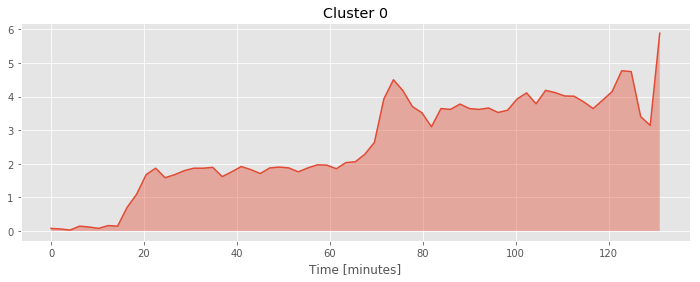

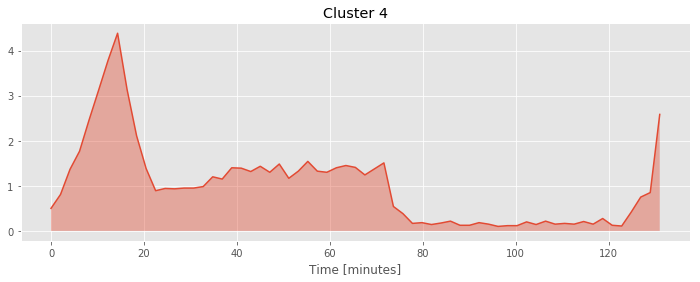

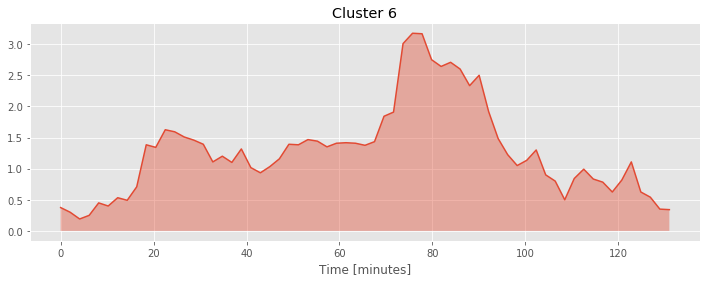

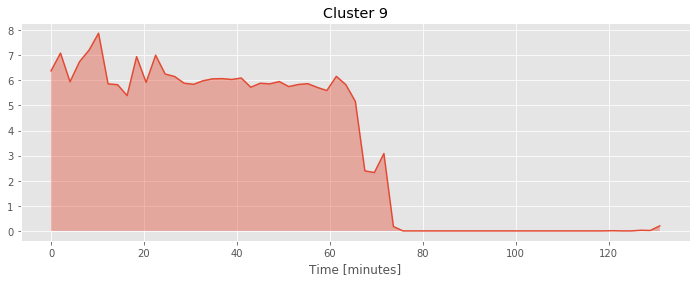

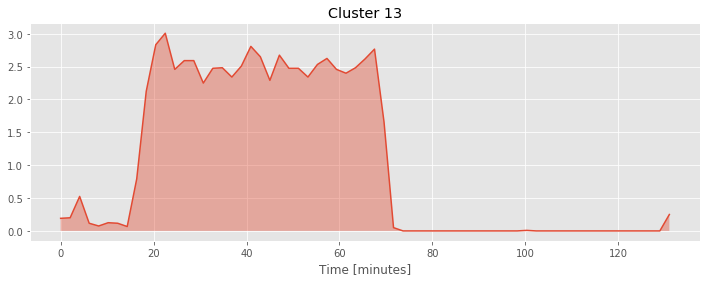

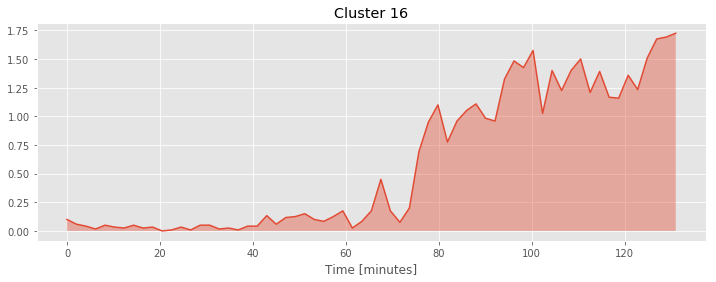

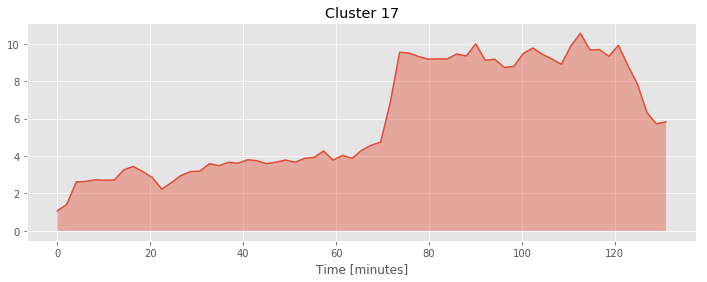

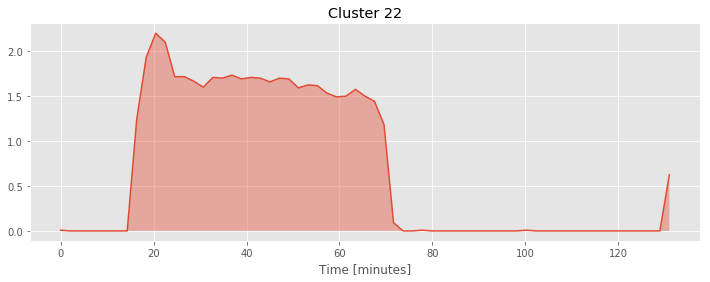

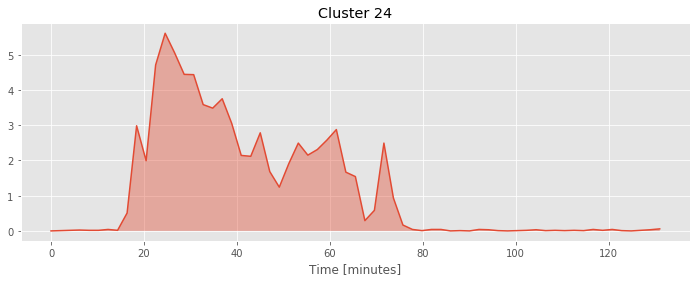

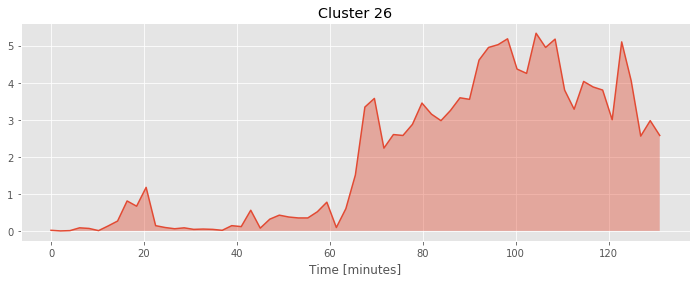

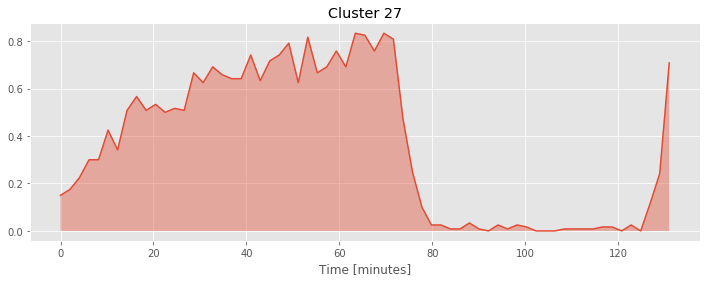

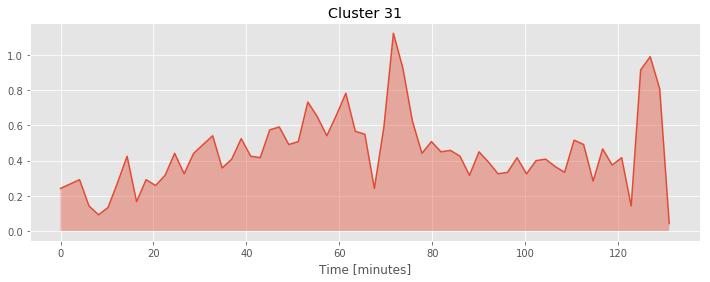

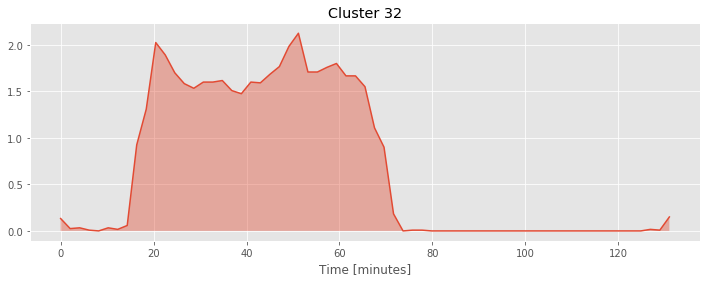

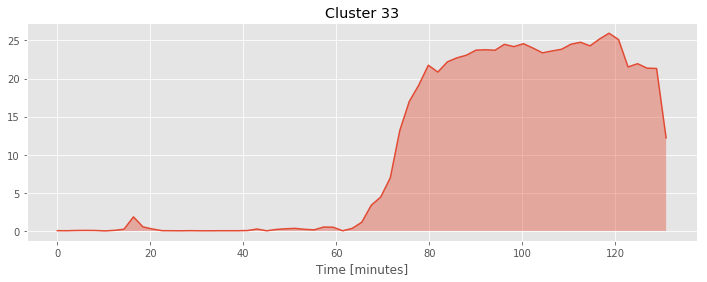

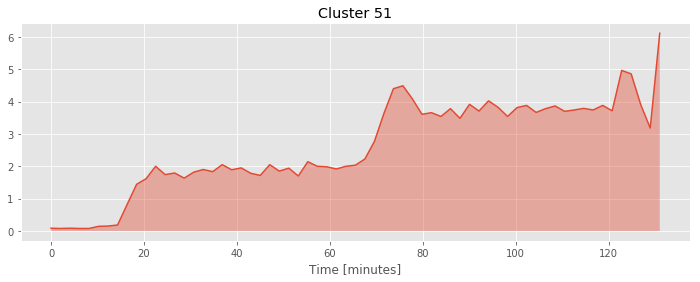

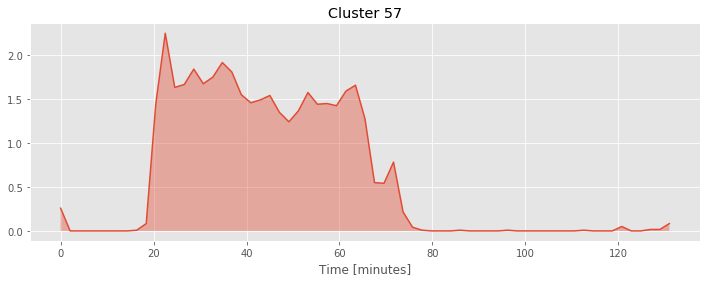

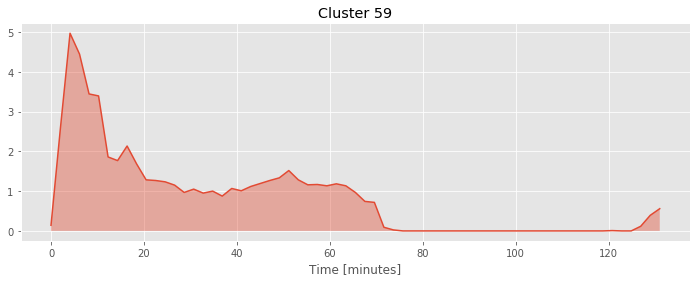

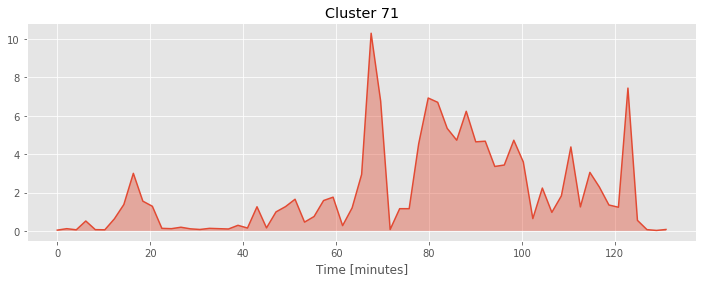

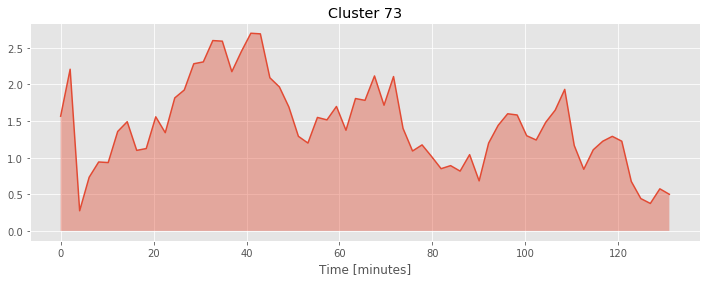

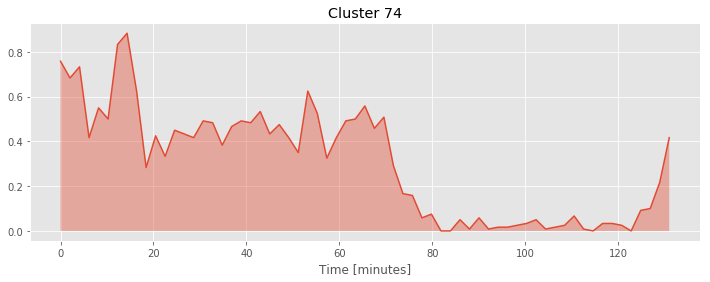

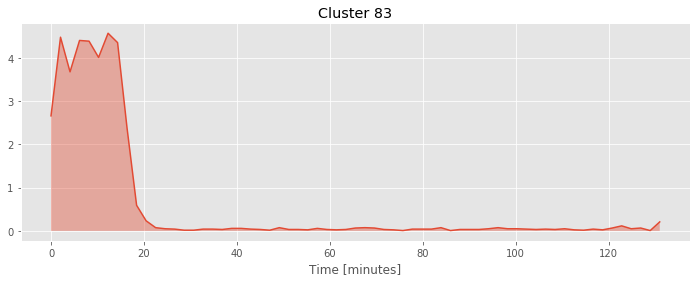

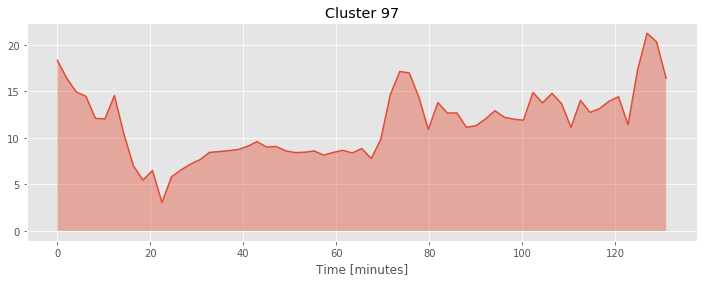

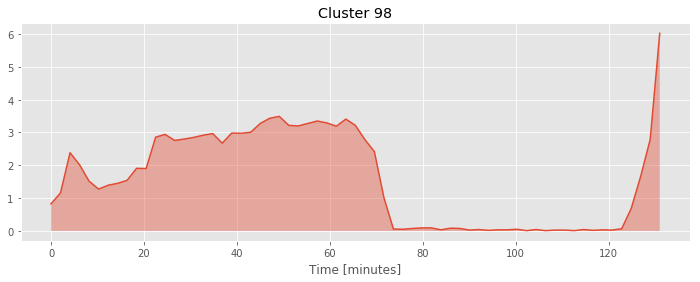

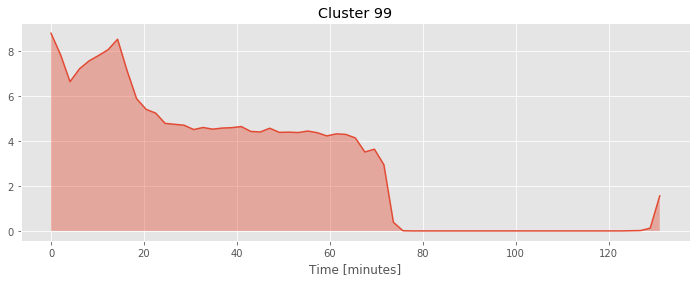

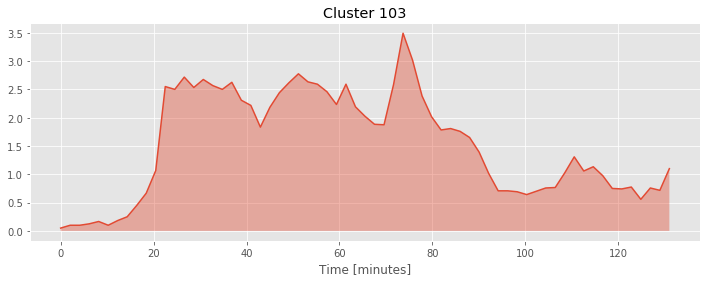

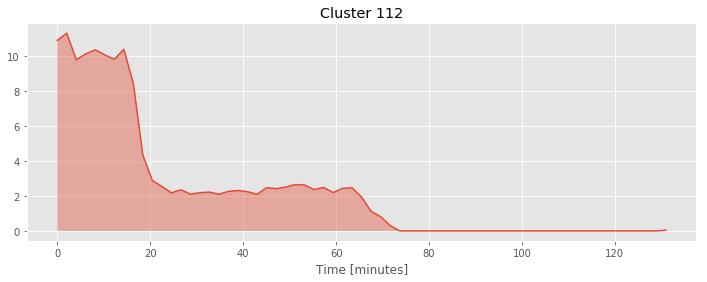

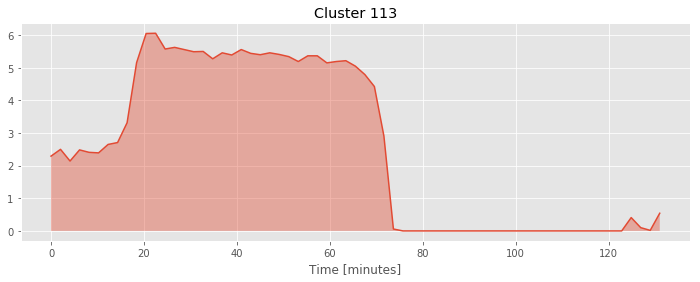

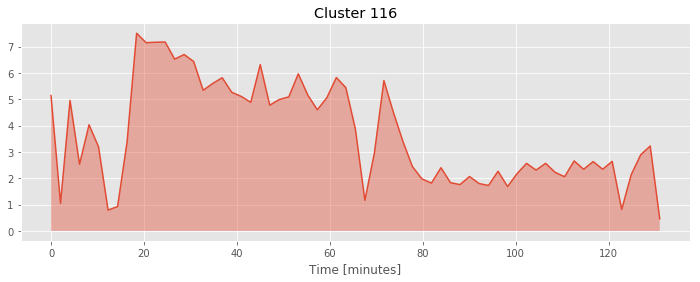

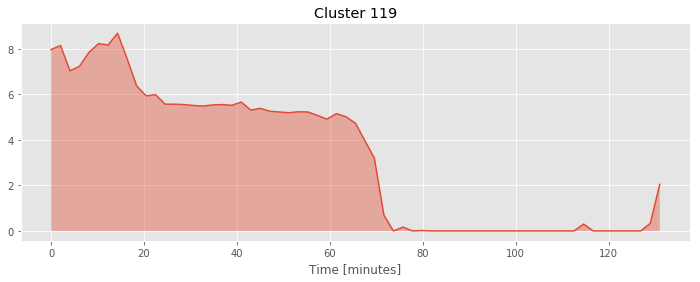

In [25]:
for cluster in df_ts_all.columns:
    num_bins_2 = np.int(np.int(max_times / 60) / 2)
    col_bins_2 = np.array_split(df_ts_all.loc[:,cluster], num_bins_2)
    firing_list = []
    for each_bin in col_bins_2:
        firing_list.append(np.sum(each_bin.notnull())/120)
    plt.figure(figsize=(12, 4))
    x = np.linspace(0, np.int(max_times / 60), len(firing_list))
    y = firing_list
    plt.plot(x, y, linewidth=1.5)
    plt.xlabel('Time [minutes]')
    plt.fill_between(x, y, alpha=0.4)
    plt.title('Cluster {clus}'. format(clus=cluster))
    plt.show()

In [1]:
def calculate_neuron_mfr_sum_notnull(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    firing_list = pd.Series(np.zeros(num_bins))
    for ind, each_bin in enumerate(col_bins):
        mfr = np.sum(each_bin.notnull())/120
        firing_list[ind] = mfr
    return firing_list

# Some weird tests

In [ ]:
chosen_cluster = 99
num_bins_2 = np.int(max_times / 60) / 2
col_bins_2 = np.array_split(df_ts_all.loc[:,chosen_cluster], num_bins_2)

In [ ]:
firing_list = []
for each_bin in col_bins_2:
    firing_list.append(np.nansum(each_bin.notnull())/120)

In [ ]:
firing_list

In [ ]:
plt.figure(figsize=(12, 4))
x = np.linspace(0, np.int(max_times / 60), len(firing_list))
y = firing_list
plt.plot(x, y, linewidth=1.5)


cit_indecator_y = (np.ones(2) * np.max(firing_list)) + 1
cit_indecator_x = np.linspace(60, np.int(max_times / 60), 2)
plt.plot(cit_indecator_x, cit_indecator_y, linewidth=4)

condition_indecator_x = np.linspace(120, np.int(max_times / 60), 2)
condition_indecator_y = np.ones(2) * np.max(firing_list) + 0.3
plt.plot(condition_indecator_x, condition_indecator_y, linewidth=4)




plt.xlabel('Time [minutes]')
plt.fill_between(x, y, alpha=0.4)
plt.title('Cluster {clus}'. format(clus=chosen_cluster))
plt.show()

In [ ]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

trace = go.Scatter(
    x = np.linspace(0, np.int(max_times / 60), len(firing_list)),
    y = firing_list,
    mode = 'markers',
)

layout= go.Layout(
    title= 'Firing Rate overtime',
    autosize=False,
    width=700,
    height=700,
    hovermode= 'closest',
    xaxis= dict(
        title= 'Time (s)',
        ticklen= 5,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title='Firing Rate',
        ticklen=5,
        gridwidth=1,
    ),
    showlegend=False
)

data = [trace]
fig = go.Figure(data=data, layout=layout)

# Plot and embed in ipython notebook!
plotly.offline.iplot(fig)

In [ ]:
condition_indecator_y = (np.ones(2) * np.max(df.iloc[:, col])) + 1
condition_indecator_x = np.linspace(60, num_mins, 2)
a[ind].plot(condition_indecator_x, condition_indecator_y, linewidth=4, label=(condition_lab_1))

In [ ]:
dfs=[mean_firing_rates_ts, cv_isis_ts]

In [ ]:
dfs[0].columns

In [ ]:
spike_times = pd.to_numeric(col_bins_2[0][col_bins_2[0].notnull()].index.values)

In [ ]:
spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)

In [ ]:
mfr = mean_firing_rate(spike_train)
mfr*10**9

In [ ]:
import os

os.mkdir('F:\\CIT_WAY\\2018-05-01_01\\figures\\Cluster no.112')